## sentiment in Dutch pressconferences on covid

### metadata
file: covid_pressconferences.ipynb

author: jan wassenaar

date: 2021-05-10

### description
Since the COVID-19 outbreak the responsible ministers in Holland have given several dozen pressconferences on this subject.
I was curious in what amount the sentiment of the text by prime minister Rutte and minister de Jonge reflects the severity of the COVID situation.

For the **sentiment** of the (Dutch) text I used the *pattern* library, which has a module for Dutch text.

As **severity** I used:
- ic: number of people with COVID on the Dutch ICU (Intensive Care Units)
- ic_in: number of COVID admissions to the ICU on a given day
- hospital: number of COVID people in the Dutch hospitals
- hospital_in: number of COVID admissions to the hospitals on a given day

### content
1. Load libraries
2. Read and preprocess the data
3. Graphs

## 1. Load libraries

In [20]:
import numpy as np
import pandas as pd

from pattern.nl import sentiment

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## 2. Read and preprocess the data

#### 2.1 text of PM rutte

In [2]:
# source: https://www.rijksoverheid.nl/onderwerpen/coronavirus-covid-19/coronavirus-beeld-en-video/videos-persconferenties

# read data
data_rutte_load = pd.read_csv(filepath_or_buffer='data/persconf_rut.csv', sep='@')
data_rutte = data_rutte_load

# fill data
data_rutte.rename(columns={'tekst_rut': 'txt_rutte'}, inplace=True)
data_rutte['date'] = pd.to_datetime(arg=data_rutte['datum'], format='%Y%m%d')
data_rutte.drop('datum', axis=1, inplace=True)

data = data_rutte

#### 2.2 text of minister de jonge

In [3]:
# source: https://www.rijksoverheid.nl/onderwerpen/coronavirus-covid-19/coronavirus-beeld-en-video/videos-persconferenties

# read data
data_dejonge_load = pd.read_csv(filepath_or_buffer='data/persconf_jon.csv', sep='@')
data_dejonge = data_dejonge_load

# fill data
data_dejonge.rename(columns={'datum': 'date', 
                          'tekst_jon': 'txt_jong'}, 
                    inplace=True)

data_dejonge['date'] = pd.to_datetime(arg=data_dejonge['date'], format='%Y%m%d')

#### 2.3 hospital data

In [4]:
# source: Excel from https://service.openinfo.nl/downloads/corona-cijfers-per-dag-op-gemeente-provincie-en-landelijk-niveau/
# tab in Excel: NICE

# read data
data_ic_load = pd.read_csv(filepath_or_buffer='data/AlleCijfers-Corona-besmet-opgenomen-overleden_nice.csv', sep=';')

# select columns
data_ic = pd.DataFrame(data=data_ic_load, columns=['Datum', 
                                                   'Aanwezig op IC verdacht of bewezen Corona',
                                                   'Aanwezig op verpleegafdeling verdacht of bewezen Corona',
                                                   'Opname IC totaal',
                                                   'Opname verpleegafdeling totaal'],
                      )

# rename columns
data_ic.rename(columns={'Datum': 'date', 
                        'Aanwezig op IC verdacht of bewezen Corona': 'ic',
                        'Aanwezig op verpleegafdeling verdacht of bewezen Corona': 'hospital',
                        'Opname IC totaal': 'ic_in',
                        'Opname verpleegafdeling totaal': 'hospital_in',
                       },
               inplace=True)

# add data that are missing in NICE but are needed
# source: https://coronadashboard.rijksoverheid.nl
data_ic = data_ic.append(other={'date': '2020-03-09', 
                                'ic': 32, 
                                'hospital': 141, 
                                'ic_in': 7, 
                                'hospital_in': 32}, 
                         ignore_index=True)

# convert to datetime
data_ic['date'] = pd.to_datetime(arg=data_ic['date'], format='%Y-%m-%d')

#### 2.4 merge data

In [5]:
data = data.merge(right=data_dejonge, how='left', on=['date'])
data = data.merge(right=data_ic, how='left', on=['date'])
data['txt_jong'].fillna(method='backfill', inplace=True)

#### 2.5 add sentiment

In [6]:
for i in range(0, len(data['txt_rutte'])):
    data.loc[i, ['pos_rutte']] = round(sentiment(data['txt_rutte'][i])[0], 3)
    data.loc[i, ['subj_rutte']] = round(sentiment(data['txt_rutte'][i])[1], 3)

for i in range(0, len(data['txt_jong'])):    
   data.loc[i, ['pos_dejonge']] = round(sentiment(data['txt_jong'][i])[0], 3)
   data.loc[i, ['subj_dejonge']] = round(sentiment(data['txt_jong'][i])[1], 3)

#### 2.6 data overview

In [7]:
# 2.5 data overview
print(data.head())
print(f'data.shape: {data.shape}')
print(data.info())

                                           txt_rutte       date  \
0  Wij zijn vandaag wederom bij elkaar geweest me... 2020-03-09   
1  Goedenavond allemaal. En zoals u inmiddels hee... 2020-03-19   
2  Goed u te zien. En belangrijk weer bij te prat... 2020-03-23   
3  Zo, goedenavond. Ik zou graag een paar dingen ... 2020-03-25   
4  Welkom. Zoals u weet was de eventuele verlengi... 2020-03-31   

                                            txt_jong    ic  hospital  ic_in  \
0  Dankjewel. Laat ik beginnen met het terugtrede...    32       141      7   
1  Dankjewel. Laat ik beginnen met het terugtrede...   296       993     68   
2  Beste mensen, het moet dus duidelijk zijn voor...   578      1675    100   
3  En dat is ook de reden dat we de maatregelen v...   759      2145    122   
4  En dat is ook de reden dat we de maatregelen v...  1192      2566    113   

   hospital_in  pos_rutte  subj_rutte  pos_dejonge  subj_dejonge  
0           32      0.085       0.558        0.194     

### 3. Graphs

#### 3.1 progress in time

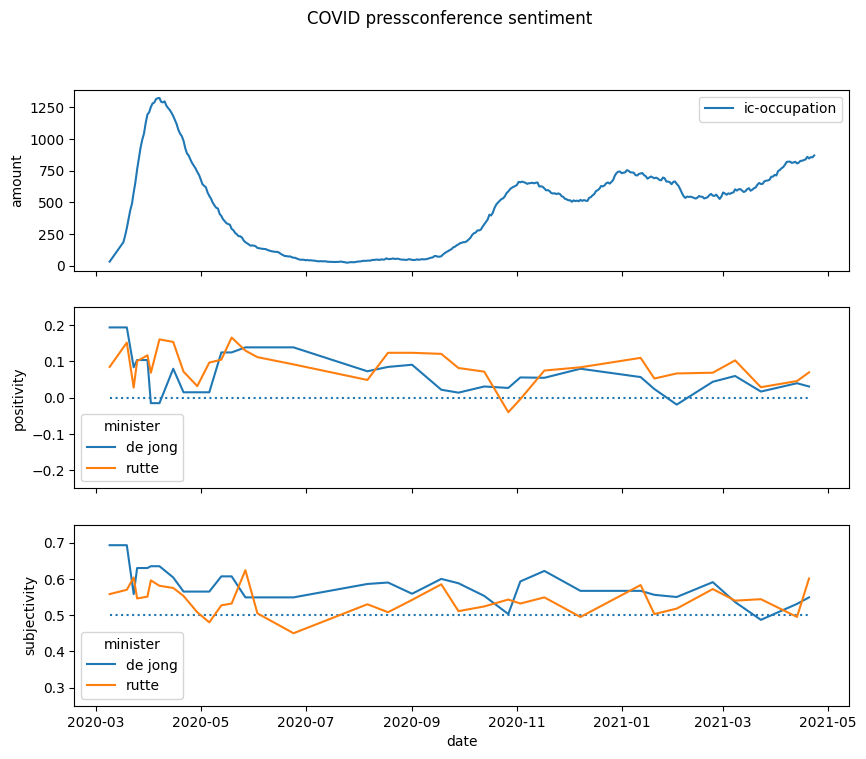

In [8]:
fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(10, 8))

fig.suptitle('COVID pressconference sentiment')

axes[0] = sns.lineplot(x='date', y='ic', data=data_ic, label='ic-occupation', ax=axes[0])

axes[0].set_ylabel('amount')

data_print = data.loc[:, ['date']]
data_print['de jong'] = data['pos_dejonge']
data_print['rutte'] = data['pos_rutte']

axes[1] = sns.lineplot(x='date', y='positivity', hue='minister', 
                        data=pd.melt(data_print, 'date', var_name='minister', value_name='positivity'), 
                       ax=axes[1])

axes[1].set_ylim(-.25, .25)
date_start = data['date'][0]
date_end = data['date'][33]
axes[1].hlines(y=0, xmin=date_start, xmax=date_end, linestyles='dotted')

data_print2 = data.loc[:, ['date']]
data_print2['de jong'] = data['subj_dejonge']
data_print2['rutte'] = data['subj_rutte']

ax = sns.lineplot(x='date', y='subjectivity', hue='minister', 
                   data=pd.melt(data_print2, 'date', var_name='minister', value_name='subjectivity'),                   
                  ax=axes[2])

axes[2].set_ylim(.25, .75)
axes[2].hlines(y=.5, xmin=date_start, xmax=date_end, linestyles='dotted')

axes[2].set_xlabel('date')

plt.show()

#### 3.2 relationship

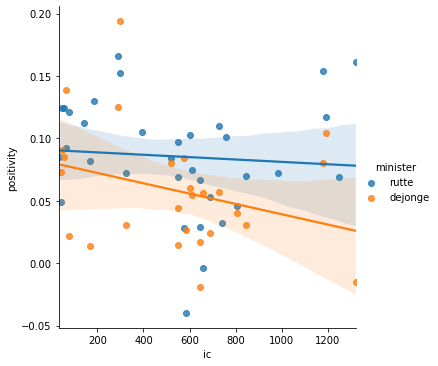

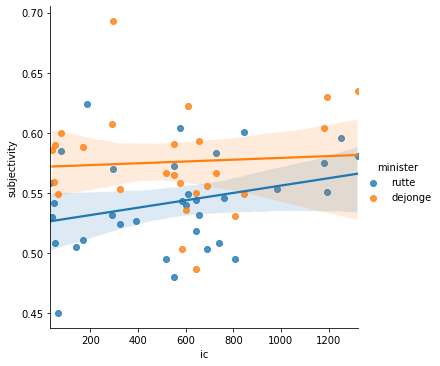

In [22]:
# text rutte
data_sentiment = data_rutte.merge(data_ic, on='date', how='left')
data_sentiment.rename(columns={'txt_rutte': 'text'}, inplace=True)
data_sentiment['minister'] = 'rutte'

# text dejonge
data_sentiment_tmp = data_dejonge.merge(data_ic, on='date', how='left')
data_sentiment_tmp.rename(columns={'txt_jong': 'text'}, inplace=True)
data_sentiment_tmp['minister'] = 'dejonge'
data_sentiment = data_sentiment.append(other=data_sentiment_tmp, ignore_index=True)

# calculate sentiment
for i in range(0, len(data_sentiment['text'])):
    data_sentiment.loc[i, ['positivity']] = round(sentiment(data_sentiment['text'][i])[0], 3)
    data_sentiment.loc[i, ['subjectivity']] = round(sentiment(data_sentiment['text'][i])[1], 3)
    
# make graph
ax = sns.lmplot(x='ic', y='positivity', hue='minister', data=data_sentiment)
ax = sns.lmplot(x='ic', y='subjectivity', hue='minister', data=data_sentiment)    

#### 3.3 clustermap

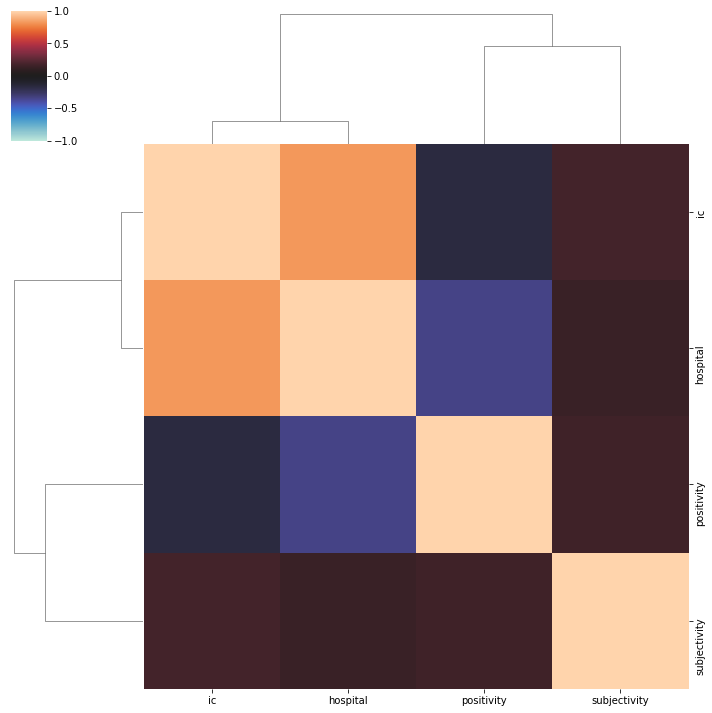

In [24]:
data_map = pd.DataFrame(data=data_sentiment, columns=['ic', 'hospital', 'positivity', 'subjectivity'])
sns.clustermap(data_map.corr(), vmin=-1.0, vmax=1.0, cmap='icefire')